## Makemore 

In [6]:
# libs
import numpy as np 
import torch 
import string
import torch.nn.functional as F
# import matplotlib
# matplotlib.use('TkAgg')  # This sets the backend to TkAgg
import matplotlib.pyplot as plt
%matplotlib inline


In [7]:
# pytorch gradients and parameters update simple example 
a=torch.tensor([10.],requires_grad=True)
b=torch.tensor([2.],requires_grad=True)

c=a+b**2
print("a",a)
print("b",b)
print("c",c)
a.grad=None
b.grad=None
c.backward()
print("gradient of a",a.grad)
print("gradient of b",b.grad)
a.data+=-0.1 * a.grad
b.data+=-0.1 * b.grad

a tensor([10.], requires_grad=True)
b tensor([2.], requires_grad=True)
c tensor([14.], grad_fn=<AddBackward0>)
gradient of a tensor([1.])
gradient of b tensor([4.])


###  Data preprocessing 

In [8]:
# Open the file in read mode
file_path = 'data/names.txt'  # Replace with your file path
with open(file_path, 'r') as file:
    lines = file.readlines()
    
names = [line.rstrip() for line in lines]


In [9]:
name=names[1]
name

'olivia'

In [10]:
# String to integer
stoi = {letter: index+1 for index, letter in enumerate(string.ascii_lowercase)}
stoi['.']=0
print(stoi)
# Integer to string
itos={v:k for k,v in stoi.items()}
print(itos)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [11]:
# block size: how many letters we use to predict the next letter 
# Buiding up the data set 
def build_dataset(names,block_size=3):
    X=[]
    Y=[]
    for name in names:
        name_dotted=block_size*'.'+name+'.'
        for i in range(len(name_dotted)-block_size):
            n=[stoi[c] for c in name_dotted[i:block_size+i]]
            X.append(n)
            Y.append(stoi[name_dotted[i+block_size]])
      
    X=torch.tensor(X)
    Y=torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y


In [12]:
# dividing the data into train/dev/test splits

import random 
random.seed(42)
random.shuffle(names)
n1=int(0.8*len(names))
n2=int(0.9*len(names))

# block size
block_size=3

Xtr,Ytr=build_dataset(names[:n1],block_size=block_size)
Xdev,Ydev=build_dataset(names[n1:n2],block_size=block_size)
Xtest,Ytest=build_dataset(names[n2:],block_size=block_size)



torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


### Makemore: MLP 

In [8]:
g=torch.Generator().manual_seed(2147483647)
embedding_size=10
n_hidden=200
vocab_size=27

# The embedding space using a lookup table C
C=torch.rand((vocab_size,embedding_size),generator=g)
#params of the first hidden layer
W1=torch.rand((embedding_size*block_size,n_hidden),generator=g)* (5/3)/((embedding_size * block_size)**0.5) # kaiming He init
b1=torch.rand((n_hidden),generator=g)*0.01
#params of the second hidden layer squashed for rapid training
W2=torch.rand((n_hidden,vocab_size),generator=g) *0.01
b2=torch.rand((vocab_size),generator=g)*0

#batch_noralization
bngain=torch.ones((1,n_hidden))
bnbias=torch.zeros((1,n_hidden))
bnmean_running=torch.zeros((1,n_hidden))
bnstd_running=torch.ones((1,n_hidden))

# parameters
parameters=[C,W1,W2,b1,b2,bngain,bnbias]

# required grad
for p in parameters:
    p.requires_grad=True
print("Number of parameters: ",sum([p.nelement() for p in parameters]))

# testing different learning rate for each batch
ls=torch.linspace(-3,0,1000)
lr=10**ls

Number of parameters:  12297


In [9]:
batch_size=32
max_steps=200000
lossi=[]

for i in range(max_steps):
    # minibatch   
    ix=torch.randint(0,Xtr.shape[0],(batch_size,))
    # forward pass
    emb=C[Xtr[ix]]
    embcat=emb.view(-1,embedding_size*block_size)
    # Linear Layer
    hpreact=embcat @ W1 +b1
    ##### batchNorm Layer
    #------------------------------------------------------------
    bnmeani=hpreact.mean(0,keepdim=True)
    bnstdi=hpreact.std(0,keepdim=True)
    hpreact=bngain*(hpreact-bnmeani)/bnstdi+bnbias
    with torch.no_grad():
        bnmean_running=0.999*bnmean_running+ 0.001*bnmeani
        bnstd_running=0.999*bnstd_running+ 0.001*bnstdi
    #-------------------------------------------------------------- 
    # Non-linearity
    h=torch.tanh(hpreact)
    logits=h@W2+b2
    loss=F.cross_entropy(logits,Ytr[ix])
    # backward pass 
    for p in parameters:
        p.grad=None
    loss.backward()
    # parameter update 
    if i<100000: lr=0.1 # learning rate decay
    else: lr=0.01
    for p in parameters:
        p.data+=-0.1*p.grad
    if i%10000==0: # print every 10000 step the loss
        print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
    lossi.append(loss.log10().item())
#     break
    
    
        


      0/ 200000: 3.293981
  10000/ 200000: 2.350360
  20000/ 200000: 2.116238
  30000/ 200000: 2.097283
  40000/ 200000: 2.514101
  50000/ 200000: 2.045030
  60000/ 200000: 2.219434
  70000/ 200000: 2.524164
  80000/ 200000: 2.184029
  90000/ 200000: 2.376915
 100000/ 200000: 2.340783
 110000/ 200000: 2.232875
 120000/ 200000: 1.987611
 130000/ 200000: 2.115477
 140000/ 200000: 2.077897
 150000/ 200000: 2.098880
 160000/ 200000: 2.184152
 170000/ 200000: 2.162163
 180000/ 200000: 2.430000
 190000/ 200000: 2.091774


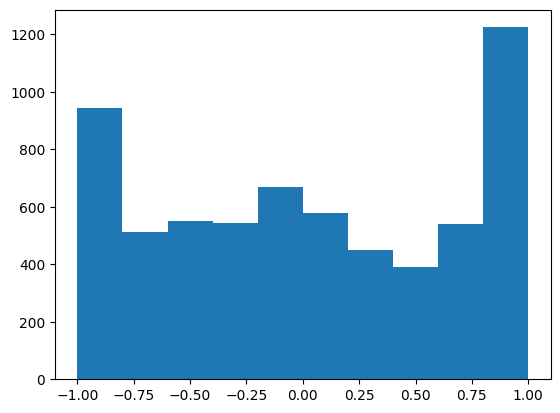

In [10]:
plt.hist(h.view(-1).tolist());

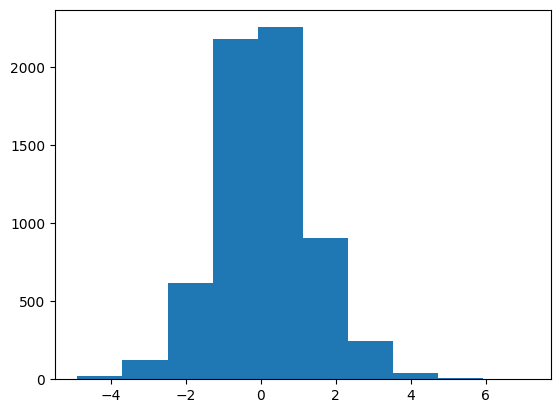

In [11]:
plt.hist(hpreact.view(-1).tolist());

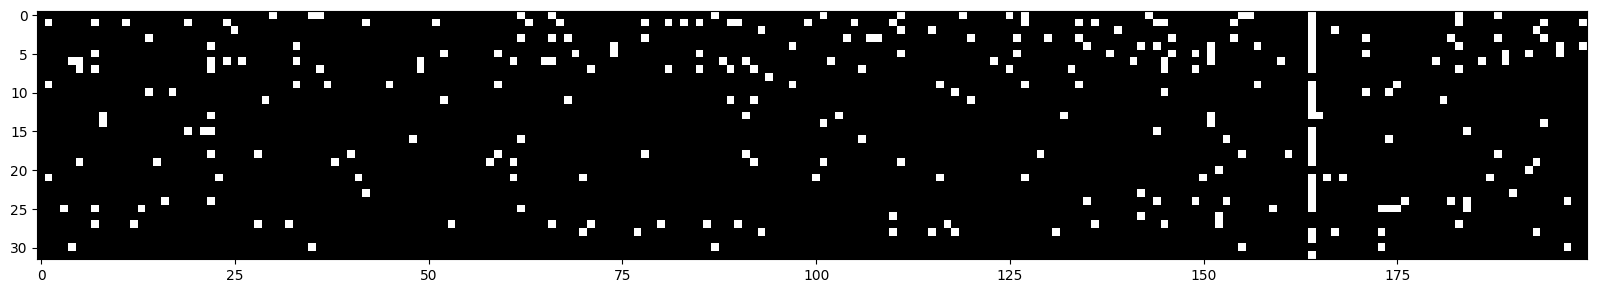

In [12]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap="gray",interpolation="nearest")

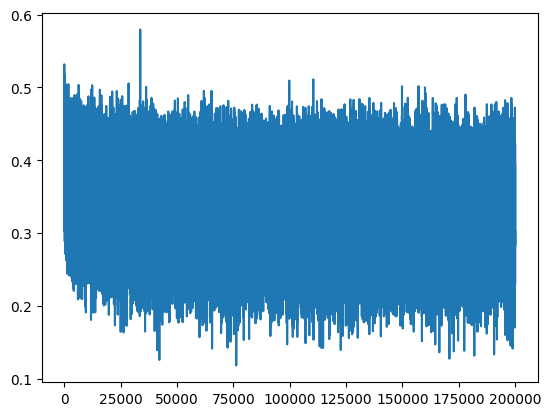

In [13]:
plt.plot(range(len(lossi)),lossi)

In [14]:
@torch.no_grad()
def split_loss(split):
    x,y={"train":(Xtr,Ytr),
         "dev":(Xdev,Ydev),
         "test":(Xtest,Ytest)}[split]
    emb=C[x]
    embcat=emb.view(-1,embedding_size*block_size)
    hpreact=embcat @ W1 +b1
    hpreact=bngain*(hpreact-bnmean_running)/bnstd_running+bnbias
    h=torch.tanh(hpreact)
    logits=h@W2+b2
    loss=F.cross_entropy(logits,y)
    print(split,loss.item())
    
split_loss("train")
split_loss("dev")


train 2.1290981769561768
dev 2.1720683574676514


In [15]:
# # visualizing the embeddings
# plt.figure(figsize=(8,8))
# plt.scatter(C[:,0].data,C[:,1].data,s=200)
# for i in range(C.shape[0]):
#     plt.text(C[i,0].item(),C[i,1],itos[i],ha="center",va="center",color="white")

In [16]:

for _ in range(20):
    context=block_size*[0]
    name=[]
    while True:
        emb=C[context]
        embcat=emb.view(-1,embedding_size*block_size)
        hpreact=embcat @ W1 +b1
        hpreact=bngain*(hpreact-bnmean_running)/bnstd_running+bnbias
        h=torch.tanh(hpreact)
        logits=h@W2+b2
        proba=F.softmax(logits,dim=1)
        n = torch.multinomial(proba, 1, replacement=True).item()
        name.append(itos[n])
        context=context[1:]+[n]
        if n==0:
            break

    print("".join(name))  

jurianasiyannie.
kalyse.
catolon.
makelynne.
avyn.
jergabri.
jiaveonleyna.
ryltiritwin.
whtekarrigna.
samailee.
aumen.
sivamayah.
kirzi.
lynnua.
rohisten.
elyanan.
alebym.
strin.
fcosselah.
haadmer.


# Pytorchfying makemore MLP

In [20]:
# libs
import numpy as np 
import torch 
import string
import torch.nn.functional as F
# import matplotlib
# matplotlib.use('TkAgg')  # This sets the backend to TkAgg
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
###### init #################
vocab_size=27
embedding_size=3
n_hidden=100
block_size=8

Xtr,Ytr=build_dataset(names[:n1],block_size=block_size)
Xdev,Ydev=build_dataset(names[n1:n2],block_size=block_size)
Xtest,Ytest=build_dataset(names[n2:],block_size=block_size)

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [23]:



class Embedding:
    
    def __init__(self,vocab_size,embedding_size):
        self.weights=torch.randn(vocab_size,embedding_size)
    
    def __call__(self,x):
        return self.weights[x]
        
    def parameters(self):
        return [self.weights]
    
    
class Flatten:
  
    def __call__(self,x):
        return x.view(x.shape[0],-1)
    
    def parameters(self):
        return []
  

class Linear:
    
    def __init__(self,fan_in,fan_out,bias=True):
        self.weights=torch.randn(fan_in,fan_out)/ fan_in**0.5
        if bias:
            self.bias=torch.zeros(1,fan_out) 
        
    def __call__(self,x):
        out=x@self.weights
        if self.bias is not None:
            out+=self.bias
            
        return out 
    
    def parameters(self):
        return [self.weights]+ ([] if self.bias is None else [self.bias] )
    
    
     
    
class batchnorm1d():

    def __init__(self,n_hidden,eps=1e-5, momentum=0.1):
        self.eps=eps
        self.momentum=momentum
        self.bngain=torch.ones(1,n_hidden)
        self.bnbias=torch.zeros(1,n_hidden)
        self.running_mean=torch.zeros((1,n_hidden))
        self.running_var=torch.ones((1,n_hidden))
        self.training=True
    
    def __call__(self,x):
        bnmeani=x.mean(0,keepdim=True)
        bnstdi=x.std(0,keepdim=True)
        
        if self.training:
            xmean=bnmeani
            xvar=bnstdi
        else:
            xmean=self.running_mean
            xvar=self.running_var
            
        xhat=((x-xmean)/(xvar+self.eps))    
        hpreact=self.bngain*xhat+self.bnbias
        
        if self.training:
          with torch.no_grad():
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        
        return hpreact
            
    
    def parameters(self):
        return [self.bngain,self.bnbias]
    


class Tanh: 
    
    def __call__(self,x):
        return torch.tanh(x)
    
    def parameters(self):
        return []
        


        
class Sequential:
    
    def __init__(self,layers):
        self.layers=layers
    
    def __call__(self,x):
        
        for layer in self.layers:
            x=layer(x)
            
        return x
    
    def parameters(self):
            return [param for layer in self.layers for param in layer.parameters()]

            
        
        
        

In [25]:
torch.manual_seed(42)

x=torch.arange(18).view(-1,3)
layers=[Embedding(vocab_size,embedding_size),
        Flatten(),
        Linear(block_size*embedding_size,n_hidden),
        batchnorm1d(n_hidden),
        Tanh(),
        Linear(n_hidden,vocab_size)]

model=Sequential(layers)
parameters=model.parameters()
for p in parameters:
    p.requires_grad=True

# model(x).shape

In [26]:
batch_size=32
max_steps=200000
lossi=[]

for i in range(max_steps):
    # minibatch   
    ix=torch.randint(0,Xtr.shape[0],(batch_size,))
    t=Xtr[ix]
    # forward pass
    logits=model(t)
    loss=F.cross_entropy(logits,Ytr[ix])
    # backward pass 
    for p in parameters:
        p.grad=None
    loss.backward()
    # parameter update 
    if i<100000: lr=0.1 # learning rate decay
    else: lr=0.01
    for p in parameters:
        p.data+=-0.1*p.grad
    if i%10000==0: # print every 10000 step the loss
        print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
    lossi.append(loss.log10().item())
#     break
    
    
        


      0/ 200000: 3.527443
  10000/ 200000: 2.563222
  20000/ 200000: 2.538853
  30000/ 200000: 2.383300
  40000/ 200000: 2.067885
  50000/ 200000: 2.323656
  60000/ 200000: 2.442737
  70000/ 200000: 2.013748
  80000/ 200000: 1.650712
  90000/ 200000: 2.053907
 100000/ 200000: 1.939847
 110000/ 200000: 2.149416
 120000/ 200000: 2.230705
 130000/ 200000: 2.065254
 140000/ 200000: 2.176979
 150000/ 200000: 2.360133
 160000/ 200000: 2.209917
 170000/ 200000: 2.112166
 180000/ 200000: 2.050550
 190000/ 200000: 2.650049


In [27]:
@torch.no_grad()
def split_loss(split):
    x,y={"train":(Xtr,Ytr),
         "dev":(Xdev,Ydev),
         "test":(Xtest,Ytest)}[split]
    logits=model(x)
    loss=F.cross_entropy(logits,y)
    print(split,loss.item())
    
split_loss("train")
split_loss("dev")

train 2.1517550945281982
dev 2.17020583152771


In [28]:
for layer in model.layers:
    layer.training=False

In [29]:

for _ in range(20):
    context=[0]*block_size
    name=[]
    while True:
        
        logits=model(torch.tensor([context]))
        proba=F.softmax(logits,dim=1)
        n = torch.multinomial(proba, 1, replacement=True).item()
        name.append(itos[n])
        context=context[1:]+[n]
        if n==0:
            break

    print("".join(name))  

aorosa.
maee.
sarikaban.
magay.
gimayle.
bnyanne.
kheellynn.
jana.
sharrielie.
mayaya.
khere.
jreyco.
phaelen.
madeish.
calawan.
kaistyn.
naxielasoi.
dreenm.
aaseel.
naroba.


C:\Users\wail.elbani\AppData\Local\Temp\ipykernel_16856\206951677.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


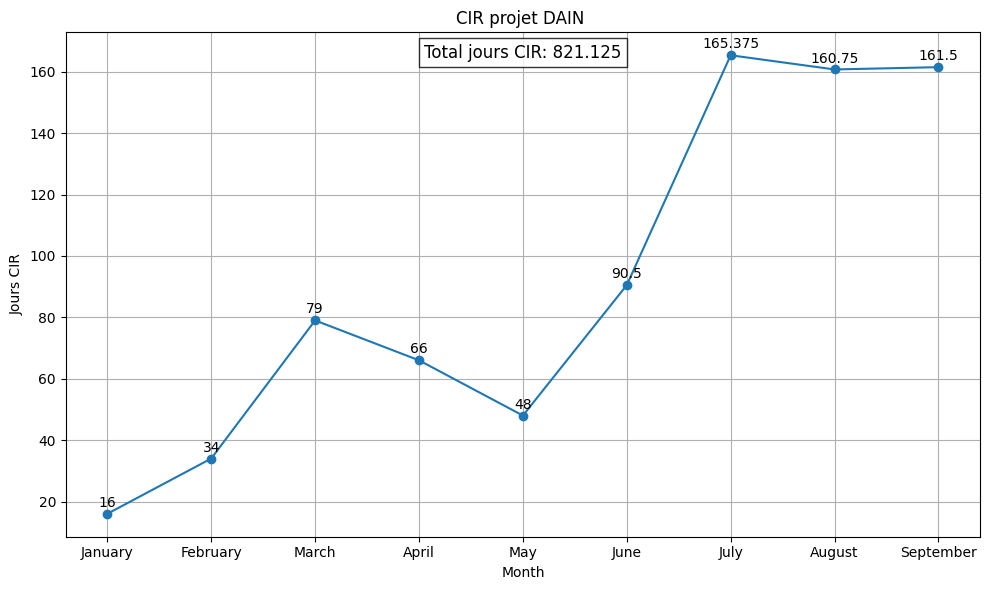

In [9]:
import matplotlib.pyplot as plt

# Data
joursCIR = [16,34,79,66,48,90.5,165.375,160.75,161.5]

# Months corresponding to the data points
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September']

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(months, joursCIR, marker='o', linestyle='-')
plt.title('CIR projet DAIN ')
plt.xlabel('Month')
plt.ylabel('Jours CIR')
plt.grid(True)
plt.tight_layout()
plt.text(0.5, 0.95, f'Total jours CIR: {sum(joursCIR)}', transform=plt.gca().transAxes, ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
for i, value in enumerate(joursCIR):
    plt.annotate(f'{value}', (months[i], value), textcoords="offset points", xytext=(0,5), ha='center')

plt.tight_layout()
# Display the plot
plt.show()
